## 1. Inicializações para o Laboratório

### 1.1 Verificar Sistema Operacional, Python e Java

In [20]:
import sys
import platform

print(f"Sistema Operacional: {platform.system()}")
print(f"Python: {sys.version}")
!java -version

Sistema Operacional: Linux
Python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


### 1.2 Instalar Bibliotecas Python Necessárias

In [10]:
# Instalar todas as dependências necessárias
!pip install -qq pyspark==3.5.0 2>nul
!pip install -qq kafka-python-ng 2>nul
!pip install -qq discord.py==2.3.2 2>nul
!pip install -qq matplotlib>=3.8.0 2>nul
!pip install -qq wordcloud>=1.9.3 2>nul
!pip install -qq pandas>=2.2.0 2>nul
!pip install -qq plotly>=5.17.0 2>nul
!pip install -qq nest_asyncio>=1.5.8 2>nul

print("Bibliotecas Python instaladas!")

Bibliotecas Python instaladas!


### 1.3 Importar Bibliotecas

In [10]:
import json
import time
import threading

# Discord
import discord
import nest_asyncio
nest_asyncio.apply()

# Kafka
from kafka import KafkaProducer, KafkaConsumer
from kafka.admin import KafkaAdminClient, NewTopic
from kafka.errors import TopicAlreadyExistsError

# Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, upper, window, to_json, struct, lit, from_json
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Visualização
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

print("Bibliotecas importadas!")

Bibliotecas importadas!


## 2. Configuração do Ambiente (Spark e Kafka)
---

### 2.1 Definir Variáveis de Ambiente

In [4]:
# Obter diretório atual do workspace
import os
WORKSPACE_DIR = os.getcwd()

os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-17-openjdk-amd64"  # Ajustar conforme seu Java
os.environ['PYSPARK_PYTHON'] = sys.executable

# Definir o diretório de trabalho para downloads e instalações
SPARK_VERSION = "3.5.0"
HADOOP_VERSION = "3"
SPARK_DOWNLOAD_DIR_NAME = f"spark-{SPARK_VERSION}-bin-hadoop{HADOOP_VERSION}"

SPARK_INSTALL_PATH = f"{WORKSPACE_DIR}/{SPARK_DOWNLOAD_DIR_NAME}"

os.environ['SPARK_HOME'] = f"{SPARK_INSTALL_PATH}"

KAFKA_VERSION = "3.6.0"
SCALA_VERSION = "2.13"
KAFKA_DIR = f"kafka_{SCALA_VERSION}-{KAFKA_VERSION}"

KAFKA_PATH = f"{WORKSPACE_DIR}/{KAFKA_DIR}"

# Configurações do projeto
SPARK_MASTER = "local[*]"
APP_NAME = "Discord Word Count Analysis"
KAFKA_HOST = "localhost:9092"
KAFKA_TOPIC_IN = "discord-input"
KAFKA_TOPIC_OUT = "wordcount-output"

INTERVAL = "0.1 seconds"
print("Variáveis de ambiente configuradas!")


Variáveis de ambiente configuradas!


### 2.2 Download e Instalação do Spark

In [5]:
# Verificar instalação do Spark
import os.path

if not os.path.exists(SPARK_INSTALL_PATH):
    print("Spark não encontrado. Baixando...")
    !wget -q https://archive.apache.org/dist/spark/spark-{SPARK_VERSION}/{SPARK_DOWNLOAD_DIR_NAME}.tgz
    !tar -xzf {SPARK_DOWNLOAD_DIR_NAME}.tgz
    !rm {SPARK_DOWNLOAD_DIR_NAME}.tgz
    print(f"Spark instalado em {SPARK_INSTALL_PATH}")
else:
    print(f"Spark já está instalado em {SPARK_INSTALL_PATH}")

# Adicionar Spark ao PATH
os.environ['PATH'] = f"{os.environ['SPARK_HOME']}/bin:{os.environ['PATH']}"

Spark já está instalado em /mnt/c/Users/yago.santos/Downloads/pspd/PSPD-Atividade-Extra2/spark-3.5.0-bin-hadoop3


### 2.3 Download e Instalação do Kafka

In [6]:
# Verificar instalação do Kafka
KAFKA_VERSION = "3.6.0"
SCALA_VERSION = "2.13"
KAFKA_DIR = f"kafka_{SCALA_VERSION}-{KAFKA_VERSION}"

if not os.path.exists(KAFKA_PATH):
    print("Kafka não encontrado. Baixando...")
    !wget -q https://archive.apache.org/dist/kafka/{KAFKA_VERSION}/{KAFKA_DIR}.tgz
    !tar -xzf {KAFKA_DIR}.tgz
    !rm {KAFKA_DIR}.tgz
    print(f"Kafka instalado em {KAFKA_PATH}")
else:
    print(f"Kafka já está instalado em {KAFKA_PATH}!")

Kafka já está instalado em /mnt/c/Users/yago.santos/Downloads/pspd/PSPD-Atividade-Extra2/kafka_2.13-3.6.0!


### 2.4 Iniciar Serviços Kafka (Zookeeper e Broker)

In [8]:
import subprocess
import socket

def is_port_open(host, port, timeout=1):
    """Verifica se uma porta está aberta"""
    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(timeout)
        result = sock.connect_ex((host, port))
        sock.close()
        return result == 0
    except:
        return False

def is_process_running(process_name):
    """Verifica se um processo está rodando"""
    try:
        result = subprocess.run(
            ['pgrep', '-f', process_name],
            capture_output=True,
            text=True
        )
        return len(result.stdout.strip()) > 0
    except:
        return False

def wait_for_service(service_name, host, port, max_wait=60):
    """Aguarda um serviço iniciar verificando a porta"""
    print(f"Aguardando {service_name} iniciar na porta {port}...")
    start_time = time.time()

    # Esperar um pouco mais antes de começar a verificar (dar tempo para o processo iniciar)
    time.sleep(2)

    while (time.time() - start_time) < max_wait:
        if is_port_open(host, port):
            # Porta aberta, aguardar mais um pouco para garantir que está pronto
            time.sleep(1)
            # Verificar novamente
            if is_port_open(host, port):
                print(f"{service_name} iniciado!")
                return True
        time.sleep(0.5)

    print(f"Timeout aguardando {service_name} (porta {port})")
    return False

# Verificar se Zookeeper já está rodando
if is_process_running("zookeeper") and is_port_open("localhost", 2181):
    print("Zookeeper já está rodando!")
    zookeeper_already_running = True
else:
    # Iniciar Zookeeper em background
    print("Iniciando Zookeeper...")
    zookeeper_process = subprocess.Popen(
        [f"{KAFKA_PATH}/bin/zookeeper-server-start.sh", f"{KAFKA_PATH}/config/zookeeper.properties"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    zookeeper_already_running = False

    # Aguardar Zookeeper iniciar (porta padrão 2181)
    if not wait_for_service("Zookeeper", "localhost", 2181, max_wait=30):
        print("Falha ao iniciar Zookeeper!")

# Verificar se Kafka Broker já está rodando
if is_process_running("kafka") and is_port_open("localhost", 9092):
    print("Kafka Broker já está rodando!")
    print("\nTodos os serviços Kafka estão prontos!")
else:
    # Iniciar Kafka Broker em background
    print("\nIniciando Kafka Broker...")
    kafka_process = subprocess.Popen(
        [f"{KAFKA_PATH}/bin/kafka-server-start.sh", f"{KAFKA_PATH}/config/server.properties"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

    # Kafka demora mais na primeira inicialização
    # Aguardar Kafka Broker iniciar (porta padrão 9092)
    if not wait_for_service("Kafka Broker", "localhost", 9092, max_wait=45):
        kafka_process.terminate()  # Matar processo com falha
        raise RuntimeError(
            "Kafka Broker não iniciou!\n\n"
            "Rodar a célula novamente ou reiniciar o kernel se o problema persistir."
        )
    else:
        print("\nTodos os serviços Kafka estão prontos!")

Zookeeper já está rodando!

Iniciando Kafka Broker...
Aguardando Kafka Broker iniciar na porta 9092...
Kafka Broker iniciado!

Todos os serviços Kafka estão prontos!
Kafka Broker iniciado!

Todos os serviços Kafka estão prontos!


### 2.5 Criar Tópicos Kafka

In [9]:
def create_kafka_topics():
    """Cria os tópicos Kafka necessários"""
    try:
        admin_client = KafkaAdminClient(
            bootstrap_servers=KAFKA_HOST,
            client_id='topic-creator'
        )

        topics = [
            NewTopic(name=KAFKA_TOPIC_IN, num_partitions=1, replication_factor=1),
            NewTopic(name=KAFKA_TOPIC_OUT, num_partitions=1, replication_factor=1)
        ]

        admin_client.create_topics(new_topics=topics, validate_only=False)
        print(f"Tópicos criados: {KAFKA_TOPIC_IN}, {KAFKA_TOPIC_OUT}")

    except TopicAlreadyExistsError:
        print(f"Tópicos já existem!")
    except Exception as e:
        print(f"Erro ao criar tópicos: {e}")

create_kafka_topics()

Tópicos já existem!


## 3. Configuração da API do Discord
---

### Como criar um Bot Discord:

1. **Acesse:** [Discord Developer Portal](https://discord.com/developers/applications)
2. **Clique em:** "New Application" → Dê um nome → Create
3. **Menu Bot:** Settings → Bot → "Add Bot" → Confirme
4. **Copie o Token:** Click "Reset Token" → Copie o token
5. **Ative Intents:**
   - Presence Intent
   - Server Members Intent
   - Message Content Intent
6. **Convide o Bot:**
   - Menu OAuth2 → URL Generator
   - Scopes: bot
   - Permissions: Read Messages/View Channels, Read Message History
   - Copie a URL gerada e cole no navegador
   - Adicione em um servidor

In [ ]:
DISCORD_TOKEN = "INSIRA_O_TOKEN_AQUI"
DISCORD_CHANNEL_ID = 1439228456817786912

## 4. Implementação do Bot Discord → Kafka Producer
---

In [11]:
class DiscordToKafkaBot(discord.Client):
    """Bot Discord que captura mensagens e envia ao Kafka"""

    def __init__(self, channel_id, update_callback=None, *args, **kwargs):
        # Configurar intents necessários
        intents = discord.Intents.default()
        intents.message_content = True
        intents.messages = True

        super().__init__(intents=intents, *args, **kwargs)

        self.channel_id = channel_id
        self.message_count = 0
        self.running = True
        self.update_callback = update_callback
        self.processed_messages = set()  # Rastrear mensagens já processadas
        self.historical_loaded = False  # Flag para controlar carga histórica

        # Inicializar Kafka Producer
        self.producer = KafkaProducer(
            bootstrap_servers=KAFKA_HOST,
            value_serializer=lambda v: json.dumps(v).encode('utf-8')
        )

    async def on_ready(self):
        """Executado quando o bot conecta"""
        print(f"Bot conectado como {self.user}")
        print(f"Monitorando canal ID: {self.channel_id}")

        # Buscar mensagens históricas
        await self.fetch_historical_messages(limit=100)

    async def fetch_historical_messages(self, limit=100):
        """Busca mensagens históricas do canal"""
        if self.historical_loaded:
            print("Mensagens históricas já foram carregadas anteriormente.")
            return

        try:
            channel = self.get_channel(self.channel_id)
            if channel:
                print(f"Buscando últimas {limit} mensagens...")
                async for message in channel.history(limit=limit):
                    if message.content and not message.author.bot:
                        # Verificar se já processou esta mensagem
                        if str(message.id) not in self.processed_messages:
                            await self.send_to_kafka(message)
                self.historical_loaded = True
                print(f"{self.message_count} mensagens históricas enviadas ao Kafka!")
        except Exception as e:
            print(f"Erro ao buscar mensagens históricas: {e}")

    async def on_message(self, message):
        """Executado quando uma nova mensagem é enviada"""
        # Ignorar mensagens de bots e de outros canais
        if message.author.bot or message.channel.id != self.channel_id:
            return

        # Ignorar mensagens vazias
        if not message.content:
            return

        await self.send_to_kafka(message)

    async def send_to_kafka(self, message):
        """Envia mensagem ao Kafka"""
        try:
            message_id = str(message.id)

            # Verificar se já processou esta mensagem
            if message_id in self.processed_messages:
                return

            data = {
                'text': message.content,
                'author': str(message.author),
                'timestamp': message.created_at.isoformat(),
                'message_id': message_id
            }

            self.producer.send(KAFKA_TOPIC_IN, value=data)
            self.producer.flush()  # Forçar envio imediato ao Kafka
            self.processed_messages.add(message_id)  # Marcar como processada
            self.message_count += 1
            # print(f"[{self.message_count}] Mensagem enviada: {message.content[:50]}...")

            if self.update_callback:
                self.update_callback()

        except Exception as e:
            print(f"Erro ao enviar ao Kafka: {e}")

    def stop(self):
        """Para o bot"""
        self.running = False
        self.producer.flush()
        self.producer.close()

print("Classe DiscordToKafkaBot definida!")

Classe DiscordToKafkaBot definida!


## 5. Configuração do Spark Streaming
---

### 5.1 Inicializar Spark Session

In [12]:
# Inicializar Spark com suporte a Kafka
spark = SparkSession.builder \
    .master(SPARK_MASTER) \
    .appName(APP_NAME) \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/spark-checkpoint") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session criada!")
print(f"Spark Version: {spark.version}")

your 131072x1 screen size is bogus. expect trouble
25/11/15 21:48:16 WARN Utils: Your hostname, Y resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/15 21:48:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/15 21:48:16 WARN Utils: Your hostname, Y resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/15 21:48:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/mnt/c/Users/yago.santos/Downloads/pspd/PSPD-Atividade-Extra2/spark-3.5.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7aac7037-b73e-4c2e-b9e9-9dd9a634dbe1;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	foun

Spark Session criada!
Spark Version: 3.5.0


### 5.2 Configurar Stream do Kafka

In [13]:
# Schema dos dados de entrada
schema = StructType([
    StructField("text", StringType(), True),
    StructField("author", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("message_id", StringType(), True)
])

# Ler stream do Kafka
kafka_stream = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", KAFKA_HOST) \
    .option("subscribe", KAFKA_TOPIC_IN) \
    .option("startingOffsets", "latest") \
    .load()

# Parsear JSON do Kafka
parsed_stream = kafka_stream.selectExpr("CAST(value AS STRING) as json") \
    .select(from_json(col("json"), schema).alias("data")) \
    .select("data.*")

print("Stream configurado para ler do Kafka!")

Stream configurado para ler do Kafka!


### 5.3 Processamento: Contagem de Palavras

In [14]:
# Explodir texto em palavras e contar
words = parsed_stream \
    .select(
        explode(split(col("text"), "\\s+")).alias("word"),
        col("timestamp").cast(TimestampType())
    ) \
    .select(
        upper(col("word")).alias("word"),
        col("timestamp")
    ) \
    .filter("length(word) > 2")  # Filtrar palavras muito curtas

# Contagem acumulada de palavras
word_counts = words \
    .groupBy("word") \
    .count() \
    .orderBy(col("count").desc())

print("Pipeline de processamento configurado!")

Pipeline de processamento configurado!


### 5.4 Preparar Saída para Kafka

In [15]:
# Formatar dados para o Kafka de saída
output_data = word_counts.select(
    col("word").alias("key"),
    to_json(struct(
        col("word"),
        col("count")
    )).alias("value")
)

print("Dados formatados para saída!")

Dados formatados para saída!


### 5.5 Iniciar Spark Streaming

In [16]:
word_count_query = output_data.writeStream \
    .outputMode("complete") \
    .format("kafka") \
    .option("kafka.bootstrap.servers", KAFKA_HOST) \
    .option("topic", KAFKA_TOPIC_OUT) \
    .option("checkpointLocation", "/tmp/spark-kafka-checkpoint") \
    .trigger(processingTime=INTERVAL) \
    .start()

print("Spark Streaming iniciado!")
print(f"Query ID: {word_count_query.id}")

Spark Streaming iniciado!
Query ID: fcd75088-7585-43c6-bbf7-e6e1eeb1845e


## 6. Consumer: Coletar Resultados do Kafka
---

In [17]:
class WordCountCollector:
    """Coleta contagens de palavras do Kafka"""

    def __init__(self):
        self.consumer = KafkaConsumer(
            KAFKA_TOPIC_OUT,
            bootstrap_servers=KAFKA_HOST,
            auto_offset_reset='earliest',
            enable_auto_commit=True,
            consumer_timeout_ms=1000,
            value_deserializer=lambda m: json.loads(m.decode('utf-8')),
            request_timeout_ms=30000,
            reconnect_backoff_ms=500
        )
        self.word_counts = {}
        self.running = False

    def start_collecting(self, duration_seconds=30):
        """Coleta dados por um período"""
        self.running = True
        start_time = time.time()
        message_count = 0

        print(f"Coletando dados por {duration_seconds} segundos...")

        try:
            while (time.time() - start_time) < duration_seconds and self.running:
                try:
                    for message in self.consumer:
                        if (time.time() - start_time) >= duration_seconds:
                            break

                        data = message.value
                        word = data.get('word', '')
                        count = data.get('count', 0)

                        if word:
                            self.word_counts[word] = count
                            message_count += 1

                            if message_count % 20 == 0:
                                print(f"   {len(self.word_counts)} palavras únicas coletadas...")

                except Exception as e:
                    if "timeout" not in str(e).lower():
                        print(f"Erro ao consumir: {e}")
                    time.sleep(1)

        finally:
            self.running = False
            print(f"\nColeta finalizada! {len(self.word_counts)} palavras únicas coletadas.")

    def get_top_words(self, n=50):
        """Retorna as N palavras mais frequentes"""
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        return dict(sorted_words[:n])

    def stop(self):
        """Para a coleta"""
        self.running = False
        self.consumer.close()

print("Classe WordCountCollector definida!")

Classe WordCountCollector definida!


### 6.1 Classe Dashboard em Tempo Real

In [20]:
from IPython.display import clear_output, display

class RealTimeDashboard:
    """Dashboard que atualiza em tempo real consumindo dados do Kafka"""

    def __init__(self, kafka_host, topic):
        self.consumer = KafkaConsumer(
            topic,
            bootstrap_servers=kafka_host,
            auto_offset_reset='earliest',
            consumer_timeout_ms=1000,
            value_deserializer=lambda m: json.loads(m.decode('utf-8')),
            enable_auto_commit=True,
            auto_commit_interval_ms=1000,
            session_timeout_ms=30000,
            heartbeat_interval_ms=3000,
            max_poll_interval_ms=300000,
            request_timeout_ms=40000,
            reconnect_backoff_ms=1000,
            reconnect_backoff_max_ms=5000,
            fetch_max_wait_ms=500
        )
        self.word_counts = {}
        self.running = False
        self.update_count = 0
        self.update_requested = threading.Event()
        self.initial_load_done = False

    def request_update(self):
        """Método chamado pelo bot para solicitar atualização do dashboard"""
        self.update_requested.set()

    def update_dashboard(self, duration_seconds=60, min_update_interval=2):
        """
        Atualiza o dashboard dinamicamente verificando novos dados periodicamente

        Args:
            duration_seconds: Tempo total de execução
            min_update_interval: Intervalo entre verificações de novos dados
        """
        self.running = True
        start_time = time.time()
        check_count = 0

        # Carga inicial dos dados históricos
        print("Carregando dados históricos do Kafka...")
        self._load_initial_data()
        self._render_dashboard(0)
        self.initial_load_done = True
        print("Dados históricos carregados! Aguardando novas mensagens...\n")

        try:
            while (time.time() - start_time) < duration_seconds and self.running:
                # Aguardar intervalo mínimo
                time.sleep(min_update_interval)

                check_count += 1
                new_words = self._consume_new_data()

                if new_words > 0:
                    elapsed = time.time() - start_time
                    self._render_dashboard(elapsed)
                    print(f"\nDashboard atualizado! (+{new_words} atualizações de palavras)")

                # Verificar se atingiu o tempo limite
                if (time.time() - start_time) >= duration_seconds:
                    break

        finally:
            self.running = False
            # Consumir dados finais
            self._consume_new_data()
            self._render_dashboard(time.time() - start_time, final=True)
            print("\nDashboard finalizado!")

    def _load_initial_data(self):
        """Carrega dados históricos do Kafka"""
        try:
            loaded = 0
            # Usar poll para ler dados históricos
            while True:
                raw_messages = self.consumer.poll(timeout_ms=2000, max_records=500)

                if not raw_messages:
                    break  # Sem mais mensagens históricas

                for topic_partition, messages in raw_messages.items():
                    for message in messages:
                        try:
                            data = message.value
                            word = data.get('word', '')
                            count = data.get('count', 0)

                            if word:
                                # Substituir, não somar (Spark envia contagens totais)
                                self.word_counts[word] = count
                                loaded += 1
                        except Exception as e:
                            print(f"Erro ao processar mensagem histórica: {e}")

            if loaded > 0:
                print(f"   Carregadas {loaded} atualizações de palavras do histórico")
            else:
                print(f"   Nenhum dado histórico encontrado (tópico vazio)")
        except Exception as e:
            print(f"Erro ao carregar dados iniciais: {e}")

    def _consume_new_data(self):
        """Consome novos dados do Kafka e retorna quantidade de atualizações"""
        updates = 0
        messages_read = 0
        try:
            # Forçar poll para buscar novos dados
            raw_messages = self.consumer.poll(timeout_ms=1000, max_records=500)

            for topic_partition, messages in raw_messages.items():
                for message in messages:
                    messages_read += 1
                    try:
                        data = message.value
                        word = data.get('word', '')
                        count = data.get('count', 0)

                        if word:
                            # Substituir contagem (Spark envia valores totais, não incrementais)
                            old_count = self.word_counts.get(word, 0)
                            self.word_counts[word] = count
                            # Contar como atualização se mudou
                            if count != old_count:
                                updates += 1
                    except Exception as e:
                        print(f"Erro ao processar mensagem: {e}")

            # Debug: mostrar quantas mensagens foram lidas
            if messages_read > 0:
                print(f"   Lidas {messages_read} mensagens do Kafka, {updates} atualizações detectadas")

        except Exception as e:
            if "timeout" not in str(e).lower():
                print(f"Erro ao consumir dados: {e}")

        return updates

    def _render_dashboard(self, elapsed_time, final=False):
        """Renderiza o dashboard com os dados atuais"""
        clear_output(wait=True)

        self.update_count += 1

        # Cabeçalho
        print(f"DASHBOARD DINÂMICO - Atualização #{self.update_count}")
        print(f"Tempo decorrido: {int(elapsed_time)}s")
        print(f"Palavras únicas: {len(self.word_counts)}")
        print(f"Status: {'FINALIZADO' if final else 'ATUALIZANDO...'}")

        if not self.word_counts:
            print("\nAguardando dados do Kafka...")
            return

        # Obter top palavras
        top_words = dict(sorted(self.word_counts.items(),
                               key=lambda x: x[1], reverse=True)[:30])

        # Estatísticas
        total_words = sum(self.word_counts.values())
        print(f"\nTotal de palavras processadas: {total_words}")

        # Criar visualizações
        self._create_visualizations(top_words, final)

    def _create_visualizations(self, word_data, final):
        """Cria as visualizações gráficas"""
        try:
            # 1. Gráfico de Barras Horizontal
            if len(word_data) > 0:
                df = pd.DataFrame(list(word_data.items()), columns=['word', 'count'])
                df = df.sort_values('count', ascending=False).head(20)

                fig = px.bar(
                    df,
                    x='count',
                    y='word',
                    orientation='h',
                    title=f'Frequência de Palavras - Discord (Top 20)',
                    labels={'count': 'Frequência', 'word': 'Palavra'},
                    color='count',
                    color_continuous_scale='Viridis',
                    text='count'
                )

                fig.update_layout(
                    height=600,
                    yaxis={'categoryorder':'total ascending'},
                    title_font_size=18,
                    showlegend=False,
                    xaxis_title="Frequência",
                    yaxis_title="Palavra"
                )

                fig.update_traces(texttemplate='%{text}', textposition='outside')
                display(fig)

            # 2. Nuvem de Palavras (apenas se tiver dados suficientes)
            if len(word_data) >= 5:
                try:
                    wordcloud = WordCloud(
                        width=1400,
                        height=700,
                        background_color='white',
                        colormap='plasma',
                        relative_scaling=0.5,
                        min_font_size=10
                    ).generate_from_frequencies(word_data)

                    plt.figure(figsize=(16, 8))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title('Nuvem de Palavras',
                             fontsize=20, pad=20, fontweight='bold')
                    plt.tight_layout()
                    plt.show()
                    plt.close()

                except Exception as e:
                    print(f"Erro ao gerar nuvem de palavras: {e}")

        except Exception as e:
            print(f"Erro ao criar visualizações: {e}")

    def stop(self):
        """Para o dashboard"""
        self.running = False
        self.consumer.close()

print("Classe RealTimeDashboard definida!")


Classe RealTimeDashboard definida!


## 7. Executar bot e dashboard em tempo real
---

### 7.1 Iniciar Bot Discord

**Execute esta célula UMA VEZ para iniciar o bot. Ele ficará rodando até você executar a célula de parar (seção 7.0.3).**

In [19]:
import asyncio
import threading

# Variável global para controlar o bot
bot_running = False
discord_bot_instance = None
bot_thread = None

def start_discord_bot_background():
    """Inicia o bot Discord em background (execução contínua)"""
    global bot_running, discord_bot_instance, bot_thread

    if bot_running:
        print("Bot já está rodando! Use a seção 7.0.3 para parar primeiro.")
        return

    async def run_bot_continuous():
        global bot_running, discord_bot_instance

        try:
            bot_running = True
            discord_bot_instance = DiscordToKafkaBot(
                channel_id=DISCORD_CHANNEL_ID,
                update_callback=None  # Sem callback aqui (dashboard usa separado)
            )

            print("Bot Discord iniciando em background...")
            print("O bot ficará ativo continuamente capturando mensagens")
            print("Use a seção 7.0.3 para parar o bot quando quiser\n")

            await discord_bot_instance.start(DISCORD_TOKEN)

        except Exception as e:
            print(f"Erro no bot: {e}")
            bot_running = False

    def run_async_bot():
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        try:
            loop.run_until_complete(run_bot_continuous())
        finally:
            loop.close()

    # Iniciar bot em thread separada
    bot_thread = threading.Thread(target=run_async_bot, daemon=True)
    bot_thread.start()

    # Aguardar bot conectar
    time.sleep(5)

    if bot_running:
        print("Bot Discord está ativo e capturando mensagens!")
        print(f"Total de mensagens: {discord_bot_instance.message_count if discord_bot_instance else 0}")
    else:
        print("Falha ao iniciar bot")

# Executar apenas se bot não estiver rodando
if not bot_running:

    start_discord_bot_background()
    print(f"Total de mensagens: {discord_bot_instance.message_count}")

else:    print("Bot já está ativo!")

Bot Discord iniciando em background...
O bot ficará ativo continuamente capturando mensagens
Use a seção 7.0.3 para parar o bot quando quiser

Bot conectado como Spark#3721
Monitorando canal ID: 1439228456817786912
Buscando últimas 100 mensagens...
84 mensagens históricas enviadas ao Kafka!
Bot Discord está ativo e capturando mensagens!
Total de mensagens: 84
Total de mensagens: 84


### 7.2 Iniciar Dashboard

DASHBOARD DINÂMICO - Atualização #7
Tempo decorrido: 601s
Palavras únicas: 18
Status: FINALIZADO

Total de palavras processadas: 540


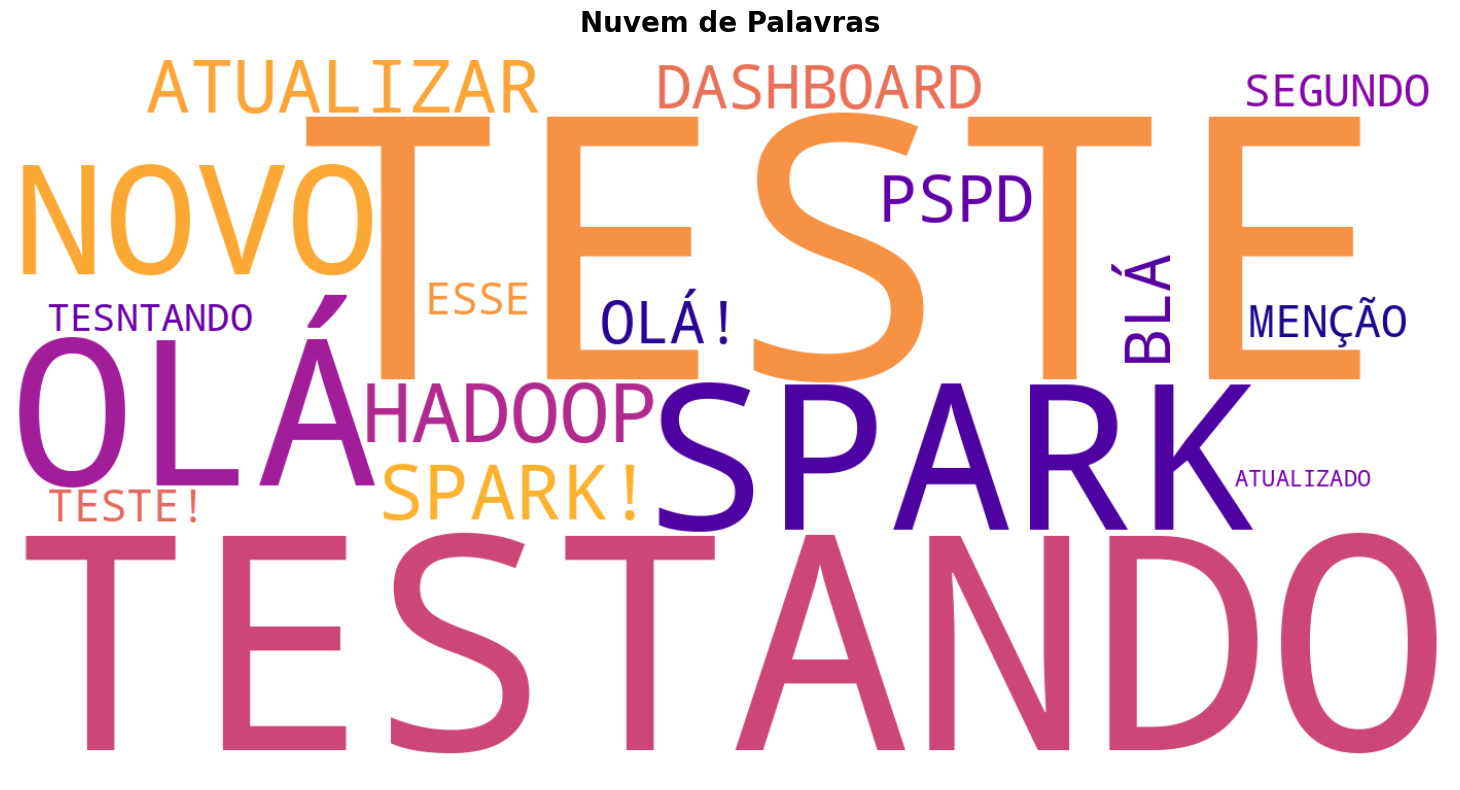


Dashboard finalizado!

Dashboard finalizado! 18 palavras únicas coletadas


In [50]:
from IPython.display import clear_output

def start_dashboard(duration_seconds, min_update_interval):
    """
    Inicia dashboard em tempo real consumindo dados do Kafka

    Args:
        duration_seconds: Tempo que dashboard ficará ativo e atualizando
        min_update_interval: Intervalo mínimo entre atualizações
    """
    print("Iniciando dashboard")

    # Verificar se Kafka está acessível
    try:
        test_consumer = KafkaConsumer(
            bootstrap_servers=KAFKA_HOST,
            consumer_timeout_ms=1000
        )
        test_consumer.close()
        print("Kafka está acessível!")
    except Exception as e:
        print(f"ERRO: Kafka não está acessível!")
        print(f"   Detalhes: {e}")
        print("\nSolução: Execute a seção 2.4 para iniciar o Kafka")
        return

    # Verificar se bot está rodando
    if not bot_running:
        print("AVISO: Bot Discord não está rodando!")
        print("O dashboard mostrará apenas dados históricos.")
        print("Execute a seção 7.0.1 para iniciar o bot.\n")
    else:
        print(f"Bot Discord ativo! ({discord_bot_instance.message_count} mensagens capturadas)\n")

    # Criar e executar dashboard
    try:
        dashboard = RealTimeDashboard(
            kafka_host=KAFKA_HOST,
            topic=KAFKA_TOPIC_OUT
        )
        print("Dashboard criado!\n")

        # Executar dashboard
        dashboard.update_dashboard(
            duration_seconds=duration_seconds,
            min_update_interval=min_update_interval
        )

        print(f"\nDashboard finalizado! {len(dashboard.word_counts)} palavras únicas coletadas")
        return dashboard.word_counts

    except KeyboardInterrupt:
        print("\nDashboard interrompido pelo usuário")
    except Exception as e:
        print(f"\nErro ao executar dashboard: {e}")
        print("\nVerifique se:")
        print("   1. Spark Streaming está rodando (seção 5.5)")
        print("   2. Tópicos Kafka foram criados (seção 2.5)")

# EXECUTAR DASHBOARD
results = start_dashboard(
    duration_seconds=600,     # 10 minutos
    min_update_interval=0.1     # Verifica novos dados a cada 0.1 segundos
)

### 7.3 Parar Bot Discord

**Execute esta célula quando quiser parar o bot Discord.**

In [25]:
async def stop_discord_bot():
    """Para o bot Discord"""
    global bot_running, discord_bot_instance

    if not bot_running:
        print("Bot não está rodando")
        return

    try:
        print("Parando bot Discord...")

        if discord_bot_instance:
            await discord_bot_instance.close()
            final_count = discord_bot_instance.message_count
            print(f"\nBot Discord parado!")
            print(f"Total de mensagens capturadas: {final_count}")

        bot_running = False
        discord_bot_instance = None

    except Exception as e:
        print(f"Erro ao parar bot: {e}")
        bot_running = False

# Parar bot
try:
    loop = asyncio.get_event_loop()
    if loop.is_running():
        nest_asyncio.apply()
        asyncio.run(stop_discord_bot())
    else:
        loop.run_until_complete(stop_discord_bot())
except:
    asyncio.run(stop_discord_bot())

Bot não está rodando


## 8. Limpeza e Finalização
---

**ATENÇÃO:** Essas células param TODOS os serviços. Use apenas quando terminar completamente!

### 8.1 Limpar Checkpoints do Spark (Sem Parar Serviços)

**Use esta célula se quiser resetar os dados históricos do Spark SEM parar os serviços.**

**IMPORTANTE:** Você precisará REINICIAR o Spark Streaming (seção 5.5) após executar esta célula!

In [24]:
import shutil

if 'word_count_query' in globals() and word_count_query.isActive:
    print("Parando Spark Streaming atual...")
    word_count_query.stop()
    import time
    time.sleep(2)
    print("Spark Streaming parado!")
checkpoint_dirs = ["/tmp/spark-checkpoint", "/tmp/spark-kafka-checkpoint"]

for checkpoint_dir in checkpoint_dirs:
    if os.path.exists(checkpoint_dir):
        try:
            shutil.rmtree(checkpoint_dir)
            print(f"Checkpoint removido: {checkpoint_dir}")
        except Exception as e:
            print(f"Erro ao remover {checkpoint_dir}: {e}")
    else:
        print(f"Checkpoint não existe: {checkpoint_dir}")

print("\nCheckpoints limpos!")

Checkpoint não existe: /tmp/spark-checkpoint
Checkpoint não existe: /tmp/spark-kafka-checkpoint

Checkpoints limpos!


### 8.2 Parar TODOS os Serviços (Finalização Completa)

In [23]:
# Parar Spark Streaming
if 'word_count_query' in globals() and word_count_query.isActive:
    word_count_query.stop()
    print("Spark Streaming parado!")
else:
    print("Spark Streaming já estava parado")

# Fechar Spark Session
if 'spark' in globals():
    spark.stop()
    print("Spark Session finalizada!")
else:
    print("Spark Session não existe")

# Parar Kafka e Zookeeper
if 'kafka_process' in globals():
    kafka_process.terminate()
    print("Kafka Broker parado!")
else:
    print("Kafka Broker não foi iniciado por este notebook")

if 'zookeeper_process' in globals():
    zookeeper_process.terminate()
    print("Zookeeper parado!")
else:
    print("Zookeeper não foi iniciado por este notebook")

print("\nTodos os serviços foram finalizados!")

Spark Streaming já estava parado
Spark Session finalizada!
Kafka Broker parado!
Zookeeper parado!

Todos os serviços foram finalizados!
Spark Session finalizada!
Kafka Broker parado!
Zookeeper parado!

Todos os serviços foram finalizados!
